In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Activation, Flatten 
from keras.layers import TimeDistributed, Conv2D, Bidirectional
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf
%matplotlib notebook

Using TensorFlow backend.


In [2]:
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(keras.__version__)

1.13.3
0.20.3
1.4.0-rc0
2.0.8


In [3]:
#f = open('sp500.csv', 'rb').read()
#data = f.decode().split('\n')def updown(a,b):

In [4]:
# load csv as np array
raw = np.loadtxt(open('snp-ohlc_4ta.csv'), delimiter=',')
len(raw)

17070

In [5]:
type(raw), len(raw[0]), raw[0], raw[-1]

(numpy.ndarray, 8, array([  1.66600000e+01,   1.66600000e+01,   1.66600000e+01,
          1.66600000e+01,   1.26000000e+06,   1.66600000e+01,
          1.66600000e+01,   0.00000000e+00]), array([  2.58320996e+03,   2.58839990e+03,   2.57491992e+03,
          2.57936011e+03,   2.21094534e+09,   2.56936793e+03,
          2.55815613e+03,  -2.03599436e+01]))

In [ ]:
raw = raw[13:]

In [6]:
# create list of sequences/window of length seqlen
# set sequence length
seqlen = 20
winraw = []
for i in range(len(raw)-seqlen):
    winraw.append(raw[i:i+seqlen,:])

In [7]:
# convert winraw to np.array
winarr = np.array(winraw)

In [8]:
winarr[0],len(winarr), len(winarr[0]),type(winarr)

(array([[  1.66600000e+01,   1.66600000e+01,   1.66600000e+01,
           1.66600000e+01,   1.26000000e+06,   1.66600000e+01,
           1.66600000e+01,   0.00000000e+00],
        [  1.68500000e+01,   1.68500000e+01,   1.68500000e+01,
           1.68500000e+01,   1.89000000e+06,   1.66945455e+01,
           1.66780952e+01,   0.00000000e+00],
        [  1.69300000e+01,   1.69300000e+01,   1.69300000e+01,
           1.69300000e+01,   2.55000000e+06,   1.67373554e+01,
           1.67020862e+01,   0.00000000e+00],
        [  1.69800000e+01,   1.69800000e+01,   1.69800000e+01,
           1.69800000e+01,   2.01000000e+06,   1.67814726e+01,
           1.67285542e+01,   0.00000000e+00],
        [  1.70900000e+01,   1.70900000e+01,   1.70800000e+01,
           1.70800000e+01,   3.85000000e+06,   1.68357503e+01,
           1.67620252e+01,   0.00000000e+00],
        [  1.70300010e+01,   1.70300010e+01,   1.70300010e+01,
           1.70300010e+01,   2.16000000e+06,   1.68710686e+01,
           1.6

In [9]:
winraw[-1][-1] == raw[-2]

array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [10]:
#halfseqlen = round(seqlen/2)
#halfseqlen

In [11]:
zz = 0
winarr[zz], winarr[zz][-1][-1],winarr[zz][0][-1]

(array([[  1.66600000e+01,   1.66600000e+01,   1.66600000e+01,
           1.66600000e+01,   1.26000000e+06,   1.66600000e+01,
           1.66600000e+01,   0.00000000e+00],
        [  1.68500000e+01,   1.68500000e+01,   1.68500000e+01,
           1.68500000e+01,   1.89000000e+06,   1.66945455e+01,
           1.66780952e+01,   0.00000000e+00],
        [  1.69300000e+01,   1.69300000e+01,   1.69300000e+01,
           1.69300000e+01,   2.55000000e+06,   1.67373554e+01,
           1.67020862e+01,   0.00000000e+00],
        [  1.69800000e+01,   1.69800000e+01,   1.69800000e+01,
           1.69800000e+01,   2.01000000e+06,   1.67814726e+01,
           1.67285542e+01,   0.00000000e+00],
        [  1.70900000e+01,   1.70900000e+01,   1.70800000e+01,
           1.70800000e+01,   3.85000000e+06,   1.68357503e+01,
           1.67620252e+01,   0.00000000e+00],
        [  1.70300010e+01,   1.70300010e+01,   1.70300010e+01,
           1.70300010e+01,   2.16000000e+06,   1.68710686e+01,
           1.6

In [12]:
trends = ['up', 'dn', 'flat']

In [50]:
# helper functions to check if uptrend, downtrend or flat
# 1st part is to get change(difference) of each window from 1st to last close
# 2nd part is to check the stats of the difference
# 3rd part is to check trend

# get range of each window by subtracting last close from 1st close
# and dividing by 1st close to get a % change
def getRange(w):
    wa = w[0][3]
    #wb = w[halfseqlen][-1]
    wc = w[-1][3]
    return (wc-wa)/wa

# check trend and give Y
def checkTrend(a,b):
    # uptrend is 1, downtrend is 2, flat is 3
    if a >= b:
        return 0
    elif a <= -b:
        return 1
    else:
        return 2


In [51]:
windowrange = []
for w in winarr:
    windowrange.append(getRange(w))


/home/john/miniconda3/envs/tfsc/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/home/john/miniconda3/envs/tfsc/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [52]:
len(windowrange), 

17050

In [53]:
absrange = [abs(x) for x in windowrange]

In [54]:
len(absrange),absrange[:10]

(17050,
 [inf,
  inf,
  inf,
  inf,
  21.000099999998486,
  inf,
  inf,
  inf,
  inf,
  7.4286918384545615])

In [55]:
max(absrange),min(absrange), np.mean(absrange)

(inf, 0.0, nan)

In [56]:
max(windowrange),np.argmax(windowrange)

(inf, 124)

In [57]:
winarr[6079]

array([[  0.00000000e+00,   9.82610939e-03,  -7.77455990e-03,
         -2.26756287e-03,   1.20504344e+05,   1.11843802e-02,
          2.25965344e-02,  -1.94406809e+00],
       [ -2.26756287e-03,   3.34733826e-03,  -1.14458265e-02,
         -5.29098364e-03,   1.07654760e+05,   8.18885948e-03,
          1.99405803e-02,  -1.98629461e+00],
       [ -5.29098364e-03,   3.56334085e-03,  -1.20937586e-02,
         -6.04684153e-03,   1.09382435e+05,   5.60055021e-03,
          1.74655877e-02,  -1.99546070e+00],
       [ -6.04684153e-03,   1.56570239e-02,  -6.04684153e-03,
          1.13379008e-02,   1.56893502e+05,   6.64370485e-03,
          1.68819985e-02,  -1.73368701e+00],
       [  1.13379008e-02,   2.62390668e-02,   5.50698623e-03,
          1.88964473e-02,   1.51386538e+05,   8.87147620e-03,
          1.70738508e-02,  -1.42183069e+00],
       [  1.88964473e-02,   3.03422629e-02,   1.23096748e-02,
          2.34315730e-02,   1.34649684e+05,   1.15187665e-02,
          1.76793481e-02,  -1.1

In [58]:
avgchg = np.mean(absrange)
avgchg

nan

In [59]:
y = []
for w in windowrange:
    y.append(checkTrend(w,avgchg-0.01))

In [60]:
y.count(0),y.count(1), y.count(2)

(0, 0, 17050)

In [61]:
# check y against winarr values
z = 0

print(winarr[z])
print(y[z])
print(winarr[z][-1][-1]-winarr[z][0][-1],(winarr[z][-1][-1]-winarr[z][0][-1])/winarr[z][0][-1])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    7.56292521e+04   0.00000000e+00   0.00000000e+00  -1.00000000e+00]
 [  1.14045618e-02   1.14045618e-02   1.14045618e-02   1.14045618e-02
    1.13444378e+05   2.07355669e-03   1.08614875e-03  -1.00000000e+00]
 [  1.62064826e-02   1.62064826e-02   1.62064826e-02   1.62064826e-02
    1.53060224e+05   4.64317959e-03   2.52618054e-03  -1.00000000e+00]
 [  1.92076831e-02   1.92076831e-02   1.92076831e-02   1.92076831e-02
    1.20647259e+05   7.29127113e-03   4.11489507e-03  -1.00000000e+00]
 [  2.58103241e-02   2.58103241e-02   2.52100840e-02   2.52100840e-02
    2.31091437e+05   1.05492371e-02   6.12396068e-03  -1.00000000e+00]
 [  2.22089436e-02   2.22089436e-02   2.22089436e-02   2.22089436e-02
    1.29650861e+05   1.26691837e-02   7.65586382e-03  -1.00000000e+00]
 [  2.58103241e-02   2.58103241e-02   2.58103241e-02   2.58103241e-02
    1.57862145e+05   1.50584820e-02   9.38486004e-03  -1.00000000e+00]
 [  6.0024009

In [62]:
len(winarr)==len(y)

True

In [63]:
winarr[0], len(winarr[0])

(array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   7.56292521e+04,   0.00000000e+00,
           0.00000000e+00,  -1.00000000e+00],
        [  1.14045618e-02,   1.14045618e-02,   1.14045618e-02,
           1.14045618e-02,   1.13444378e+05,   2.07355669e-03,
           1.08614875e-03,  -1.00000000e+00],
        [  1.62064826e-02,   1.62064826e-02,   1.62064826e-02,
           1.62064826e-02,   1.53060224e+05,   4.64317959e-03,
           2.52618054e-03,  -1.00000000e+00],
        [  1.92076831e-02,   1.92076831e-02,   1.92076831e-02,
           1.92076831e-02,   1.20647259e+05,   7.29127113e-03,
           4.11489507e-03,  -1.00000000e+00],
        [  2.58103241e-02,   2.58103241e-02,   2.52100840e-02,
           2.52100840e-02,   2.31091437e+05,   1.05492371e-02,
           6.12396068e-03,  -1.00000000e+00],
        [  2.22089436e-02,   2.22089436e-02,   2.22089436e-02,
           2.22089436e-02,   1.29650861e+05,   1.26691837e-02,
           7.6

In [64]:
winarr.shape,type(winarr),type(winarr[0]),type(winarr[0][0]),type(winarr[0][0][0])

((17050, 20, 8), numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.float64)

In [65]:
# normalize X
for w in winarr:
    #print(w[0][0])
    w/=w[0][0]
    w -= 1

/home/john/miniconda3/envs/tfsc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/john/miniconda3/envs/tfsc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [66]:
winarr[1]

array([[ nan,  nan,  nan,  nan,  inf, -inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf],
       [-inf, -inf, -inf, -inf,  inf,  inf, -inf, -inf],
       [-inf, -inf, -inf, -inf,  inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf,  inf, -inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf],
       [ nan,  nan,  nan,  nan,  inf, -inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf],
       [ inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf],
       [-inf, -inf, -inf, -inf,  inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf,  inf, -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf,

In [67]:
winarr.shape

(17050, 20, 8)

In [68]:
# convert yr and winnorm to np.array
yarr = np.array(y)
#winnormarr = np.array(winnorm)

In [69]:
yarr.shape, winarr.shape

((17050,), (17050, 20, 8))

In [70]:
# reshape yarr
yarr = np.reshape(yarr,(yarr.shape[0],1))
yarr.shape, winarr.shape

((17050, 1), (17050, 20, 8))

In [71]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
#x_data,y_data = unison_shuffled_copies(x_data,y_data)

In [72]:
row = round(0.8 * winarr.shape[0])

In [73]:
#train = winnormarr[:int(row), :]

In [74]:
#np.random.shuffle(train)

In [75]:
x_train = winarr[:row]
y_train = yarr[:row]

In [76]:
x_test = winarr[int(row):]
y_test = yarr[int(row):]

In [77]:
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((13640, 20, 8), (13640, 1), (3410, 20, 8), (3410, 1))

In [78]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2])) 

In [79]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13640, 20, 8), (13640, 1), (3410, 20, 8), (3410, 1))

In [80]:
# convert class vectors to binary class matrices
num_classes = len(trends)
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

In [81]:
inputshape = ( x_train.shape[1], x_train.shape[2]) #,x_train.shape[3])
print(inputshape)

(20, 8)


In [82]:
# define the input shape
inp = Input(shape=inputshape)

In [83]:

#print('our input shape is ',(x_train.shape[1], x_train.shape[2]) )
#x = TimeDistributed(Conv2D(32,(2,2), activation='relu'))(inp)
#x = TimeDistributed(Flatten())(x)

x = LSTM(32, return_sequences = True)(inp) 
#x = Dropout(0.2)(x)
x = LSTM(64, return_sequences = False, go_backwards=True)(x)
#x = Dropout(0.2)(x)

#x = TimeDistributed(Conv2D(32,(2,2), activation='relu')0)(x)
x = Dropout(0.2)(x)
#x = Flatten()(x)
output = Dense(num_classes, activation ='softmax')(x)

model = Model(inputs = inp, outputs=output )

In [84]:
#optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 8)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 32)            5248      
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 30,275
Trainable params: 30,275
Non-trainable params: 0
_________________________________________________________________


In [86]:
history = model.fit(x_train, y_train,
                    batch_size = 64, 
                    epochs=200, 
                    verbose=1, 
                    validation_data=(x_test, y_test))

Train on 13640 samples, validate on 3410 samples
Epoch 1/200
 9536/13640 [===================>..........] - ETA: 2s - loss: 1.1921e-07 - acc: 0.0000e+00

KeyboardInterrupt: 

In [50]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

<IPython.core.display.Javascript object>


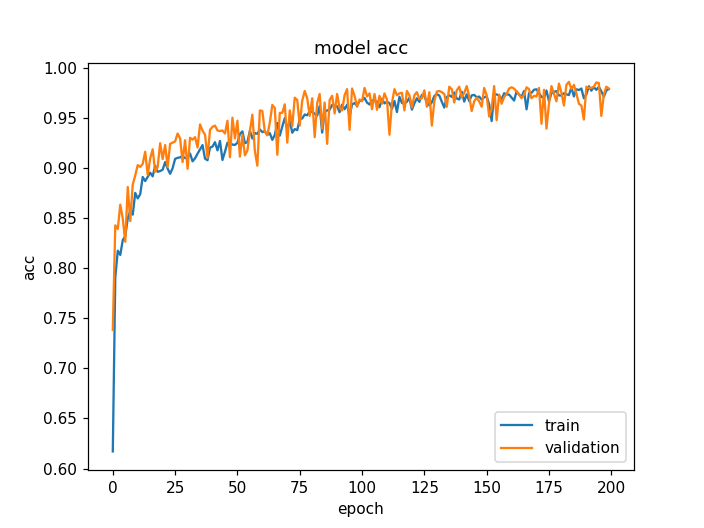

In [51]:
plot_train(history)

In [53]:
evaluation = model.evaluate(x_test, y_test, batch_size=512)
print('Model Accuracy = {:.2f} %'.format(evaluation[1]*100))
print('Model Loss = {:05.2f}'.format(evaluation[0]))

1536/1648 [==========================>...] - ETA: 0sModel Accuracy = 97.94 %
Model Loss = 00.05
